In [2]:
import numpy as np
import pandas as pd
import gensim
import os
import glob
import re
from collections import Counter
import ntpath
import sys
import json
import nltk
import random
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.stem import *
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tensorflow import keras
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

In [3]:
#specify the path
path = '../data/headlines/'
ndaq_filepath = '../data/NDAQ.csv'
cleanedPath = './cleaned/'
os.makedirs(cleanedPath, mode=0o777, exist_ok=True)

In [4]:
def path_leaf(x):
    head, tail = ntpath.split(x)
    return tail or ntpath.basename(head)

In [5]:
# gets all the files in the directory
dir_name = "./"
all_files = os.listdir(dir_name)

# removes all .txt files before starting to run the program
for item in all_files:
    if item.endswith(".txt"):
        os.remove(os.path.join(dir_name, item))

read = False

titles = {}

# getting all files in single file for words count
for filename in glob.glob(os.path.join(path, '*')):
#     print(filename)
    titleList = []
    with open(filename, 'r') as infile, open((cleanedPath+path_leaf(filename)), 'w') as outfile:
#         print(infile)
        lines = infile.readlines()
        for line in lines:
            if read:
                outfile.write(line[2:-2] + "\n")
                titleList.append(line[2:-2])
            if line == "sg6\n":
                read = True
            else:
                read = False
        titles[path_leaf(filename)[:-4]] = titleList

infile.close()
outfile.close()

# for k,v in titles.items():
#     print(k, len(v))

In [6]:
titles = {}
for filename in glob.glob(os.path.join(cleanedPath, '*')):
    with open(filename, 'r') as f:
        lines = f.readlines()
        titles[path_leaf(filename)[:-4]] = lines

## preprocessing

In [9]:
nltk.download('wordnet')
#stem, lemmatize data
def preprocess(text, stemmer):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token)>3:
            stemmed_tokens = stemmer.stem(WordNetLemmatizer().lemmatize(token, pos = 'v'))
            result.append(stemmed_tokens)
    return result

[nltk_data] Downloading package wordnet to /home/d/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
#select subset of documents 
def select_input(reg, titles):
    pattern = re.compile(reg)
    doc_subset = {k:titles[k] for k in titles.keys() if pattern.match(k)}
    return doc_subset

In [11]:
#sepecify ndaq data path
# get stocks and filter dates 
def preprocess_y(doc_subset):
    data_ndaq = pd.read_table(ndaq_filepath, delimiter=',', index_col=0, header = 0)
    data_ndaq.index = [date.replace('-', '') for date in data_ndaq.index]
    common_dates = np.intersect1d(np.asarray(list(doc_subset.keys())), data_ndaq.index)
    headline_dates = np.asarray(list(doc_subset.keys()))
    headline_idx = np.where(np.isin(headline_dates, common_dates))[0]
    data_ndaq = data_ndaq.loc[common_dates,]
    data_ndaq['change'] = data_ndaq.Open - data_ndaq.Close
    #not ordered as common_dates 
    doc_subset = {k:v for k, v in doc_subset.items() if k in common_dates}
    return data_ndaq, doc_subset

In [12]:
doc_subset = select_input(r'^(2014)|(2015)|(2016).*', titles)
data_ndaq, doc_subset = preprocess_y(doc_subset)
data_ndaq.head()

,Open,High,Low,Close,Adj Close,Volume,change
20140102,39.889999,39.959999,39.150002,39.200001,36.070358,1051300,0.689998
20140103,39.290001,39.980000,39.290001,39.779999,36.604061,1222300,-0.489998
20140106,39.689999,40.049999,39.500000,39.880001,36.696068,1525000,-0.190002
20140107,40.110001,40.369999,39.799999,40.070000,36.870899,917300,0.040001
20140108,40.700001,40.740002,40.020000,40.180000,36.972111,1714900,0.520001


In [13]:
#n_headline count
n_headlines = 0
for i,headline_count in enumerate(map(lambda x: len(x), list(doc_subset.values()))):
    n_headlines += headline_count
    
print(n_headlines)

1737490


In [14]:
def do_call(doc_raw):
    stemmer = SnowballStemmer('english')
    doc_preprocessed = {}
    for date, doc in doc_raw.items():
        doc_preprocessed[date] = [preprocess(headline, stemmer) for headline in doc]
        
    return doc_preprocessed

In [15]:
%%time
doc_preprocessed = do_call(doc_subset)

CPU times: user 5min 56s, sys: 872 ms, total: 5min 57s
Wall time: 5min 57s


## Bag of words conversion for gensim TF-IDF model

In [20]:
#get dictionary for headlines
def get_dict(doc):
    return gensim.corpora.Dictionary(doc)

In [21]:
#convert dictionary to bag-of-words model
def generate_bow(doc_list):
    doc_dict = get_dict(doc_list)
    doc_bow = [doc_dict.doc2bow(headline) for headline in doc_list]
    return doc_bow, doc_dict

In [22]:
doc_all = [headline for k,v in doc_preprocessed.items()
                      for headline in v]

In [23]:
%%time
doc_bow, doc_dict = generate_bow(doc_all)

CPU times: user 37.6 s, sys: 412 ms, total: 38 s
Wall time: 38 s


In [24]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [25]:
all_words = [word for line in doc_all
             for word in line]

word_freq = nltk.FreqDist(all_words)
filter_words = [k for k,v in word_freq.items() if v<4]

In [26]:
def filter_doc(line):
    l = [word for word in line if word not in filter_words]
    return l

In [ ]:
%%time
doc_all_filt = []
doc_all_filt = Parallel(n_jobs=num_cores)(delayed(filter_doc)(i) for i in doc_all)

In [ ]:
%%time
doc_bow, doc_dict = generate_bow(doc_all_filt)

## TF-IDF 

In [ ]:
from gensim import corpora, models

tfidf = models.TfidfModel(doc_bow)

In [ ]:
%%time
doc_tfidf = tfidf[doc_bow]

## train LDA

In [ ]:

# get doc topic distribution
n_topics = 15

def run_lda(n_topics, doc_tfidf):
    doc_lda = gensim.models.LdaMulticore(doc_tfidf, num_topics = n_topics, id2word = doc_dict,
                                         passes = 3, minimum_probability=0.0)
    for i, t in doc_lda.print_topics(-1):
        print('Topic: {} Word: {} '.format(i,t))
        
    doc_topic_dist_tup = doc_lda.get_document_topics(doc_tfidf, minimum_probability=0.0)
    doc_topic_prob = np.zeros(shape= (len(doc_topic_dist_tup), n_topics), dtype = "float64")
    for i, top_dist in enumerate(doc_topic_dist_tup):
        doc_topic_prob[i,:] = np.asarray(top_dist)[:,1]
        
    return doc_lda, doc_topic_prob

In [ ]:
doc_lda.save('../data/lda15')

In [ ]:
%%time
doc_lda_filt, doc_topic_prob = run_lda(n_topics, doc_tfidf)

In [20]:
%%time
doc_lda, doc_topic_prob = run_lda(n_topics, doc_tfidf)

Topic: 0 Word: 0.009*"updat" + 0.008*"say" + 0.008*"court" + 0.006*"rule" + 0.006*"deal" + 0.005*"probe" + 0.004*"china" + 0.004*"bank" + 0.004*"case" + 0.004*"judg" 
Topic: 1 Word: 0.039*"market" + 0.029*"research" + 0.012*"global" + 0.010*"report" + 0.008*"forecast" + 0.008*"industri" + 0.007*"analysi" + 0.007*"drug" + 0.005*"clinic" + 0.005*"trend" 
Topic: 2 Word: 0.032*"rate" + 0.032*"variabl" + 0.017*"bank" + 0.014*"citibank" + 0.014*"deutsch" + 0.011*"york" + 0.011*"russia" + 0.011*"ukrain" + 0.010*"mellon" + 0.007*"syria" 
Topic: 3 Word: 0.052*"form" + 0.020*"group" + 0.019*"barclay" + 0.013*"manag" + 0.008*"vanguard" + 0.008*"capit" + 0.007*"morgan" + 0.007*"corpor" + 0.006*"ball" + 0.006*"limit" 
Topic: 4 Word: 0.009*"award" + 0.007*"total" + 0.006*"messag" + 0.005*"name" + 0.005*"right" + 0.005*"busi" + 0.004*"vote" + 0.004*"announc" + 0.004*"year" + 0.004*"season" 
Topic: 5 Word: 0.016*"appoint" + 0.014*"watch" + 0.013*"director" + 0.013*"factor" + 0.012*"offic" + 0.011*"chi

In [22]:
#Uncomment and run this for LDA vis

#import pyLDAvis
#import pyLDAvis.gensim
#LDAvis_prepared = pyLDAvis.gensim.prepare(doc_lda, doc_bow, doc_dict)
#pyLDAvis.display(LDAvis_prepared)
#
#pyLDAvis.save_html(LDAvis_prepared, './ldavis15.html')

/home/d/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


CPU times: user 5min 19s, sys: 2.09 s, total: 5min 21s
Wall time: 5min 48s


In [24]:
#broadcast arrays
def modify_input(n_headlines, n_topics = n_topics, doc_subset = doc_subset, fwd = 0):
    y = np.zeros(shape= (n_headlines, 1), dtype = "float64")
    X = np.zeros(shape = (n_headlines, n_topics), dtype = "float64")
    dates = list(doc_subset.keys())
    start = 0
    for i,day_headline_count in enumerate(map(lambda x : len(x), list(doc_subset.values())[0:len(dates)-fwd])):
        y[start:(start+day_headline_count),0] = data_ndaq.loc[dates[i+fwd]]['change']
        print("start: ", start, "end : ", start+day_headline_count)
        X[start:(start+day_headline_count),:] = doc_topic_prob[start:(start+day_headline_count),]
        start += day_headline_count
        
    return X, y

In [25]:
X, y = modify_input(n_headlines, n_topics, doc_subset=doc_subset, fwd = 1)

start:  0 end :  3871
start:  3871 end :  7221
start:  7221 end :  8822
start:  8822 end :  12444
start:  12444 end :  15890
start:  15890 end :  19216
start:  19216 end :  23761
start:  23761 end :  24687
start:  24687 end :  28053
start:  28053 end :  30693
start:  30693 end :  32261
start:  32261 end :  36397
start:  36397 end :  40155
start:  40155 end :  41849
start:  41849 end :  42257
start:  42257 end :  42700
start:  42700 end :  43766
start:  43766 end :  46541
start:  46541 end :  48010
start:  48010 end :  51385
start:  51385 end :  55132
start:  55132 end :  55551
start:  55551 end :  57940
start:  57940 end :  61229
start:  61229 end :  64484
start:  64484 end :  67015
start:  67015 end :  70620
start:  70620 end :  72790
start:  72790 end :  75897
start:  75897 end :  76141
start:  76141 end :  79964
start:  79964 end :  81575
start:  81575 end :  86311
start:  86311 end :  89871
start:  89871 end :  93593
start:  93593 end :  95057
start:  95057 end :  98465
start:  984

start:  854500 end :  857949
start:  857949 end :  859294
start:  859294 end :  860972
start:  860972 end :  865637
start:  865637 end :  868940
start:  868940 end :  871516
start:  871516 end :  875053
start:  875053 end :  878680
start:  878680 end :  883199
start:  883199 end :  884946
start:  884946 end :  886369
start:  886369 end :  887555
start:  887555 end :  891015
start:  891015 end :  892740
start:  892740 end :  896666
start:  896666 end :  896996
start:  896996 end :  898297
start:  898297 end :  898589
start:  898589 end :  902225
start:  902225 end :  905804
start:  905804 end :  906145
start:  906145 end :  907513
start:  907513 end :  911739
start:  911739 end :  914956
start:  914956 end :  915795
start:  915795 end :  917247
start:  917247 end :  920521
start:  920521 end :  920892
start:  920892 end :  924518
start:  924518 end :  928095
start:  928095 end :  931527
start:  931527 end :  935035
start:  935035 end :  939021
start:  939021 end :  942170
start:  942170

In [26]:
y_binclass = np.asarray([1 if change>0 else 0 for change in y]).reshape(-1,1)

In [27]:
# add sentiment score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
scores = np.zeros(shape = (n_headlines,4), dtype = 'float32')
i = 0
for day in doc_subset.values():
    for headline in day:
        scores[i,] = list(sid.polarity_scores(headline).values())
        i+=1

X_sent = np.hstack((X, scores))

/home/d/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [28]:
# filter rows with abs(y) > 0.5 
cut = 0.5
X_filt = X_sent[np.where(np.abs(y)>cut)[0],]
y_cut = y[np.where(np.abs(y)>cut)[0]]
y_bin_filt = y_binclass[np.where(np.abs(y)>cut)[0]]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_filt, y_bin_filt, test_size = 0.25, random_state = 40)

In [ ]:
# create keras tensorflow model 
def init_model(n_features, n_nodes1 = 800, n_nodes2 = 10, n_nodes3 = 10, n_output = 1, 
               loss = 'mse', metric = ['accuracy'],
               act = tf.nn.relu, act_out = keras.activations.linear):
    print(n_nodes1, n_nodes2, n_output, loss, metric, act)
    tf_model = keras.Sequential([
            keras.layers.Dense(n_nodes1, activation = act, input_dim = n_features),
            keras.layers.Dense(n_nodes2, activation = act),
            keras.layers.Dense(n_output, activation=act_out)])
        
    tf_model.compile(optimizer= 'adam', 
                loss = loss,
                metrics = metric)
    return tf_model

# used for model selection
def run_tf(model, X_train, y_train, X_test, y_test, epochs = 5):   
        
        model.fit(X_train, y_train, epochs = epochs)
        _loss, _accuracy = model.evaluate(X_test, y_test)
        
        return _loss, _accuracy

In [ ]:
n_features = X_train.shape[1]
# test run
#create model
model = init_model(n_features=n_features, n_nodes1 = 800, n_nodes2 = 10, n_output = 1, 
                   act = tf.nn.relu, act_out = tf.nn.sigmoid, 
                   loss = keras.losses.binary_crossentropy, metric = ['accuracy'])
#train model
model.fit(X_train, y_train, epochs=10)
y_pred = model.predict(X_test)

In [ ]:
y_p = np.asarray([1 if val>0.5 else 0 for val in y_pred]).reshape(-1,1)
print('accuracy: ', sum(y_p == y_test)/len(y_p))

In [ ]:
del doc_all, doc_dict, doc_preprocessed, doc_tfidf, doc_topic_prob, doc_bow

### heatmap

In [32]:
import seaborn as sns
import gc
gc.collect()

157

In [30]:
# heatmap
tops = list(range(1,16))
tops.extend(['neg','neu','pos','comp','y'])
df = pd.DataFrame(np.hstack((X_filt, y_bin_filt)), columns=tops)

corr = df.corr()

In [ ]:
df.head()

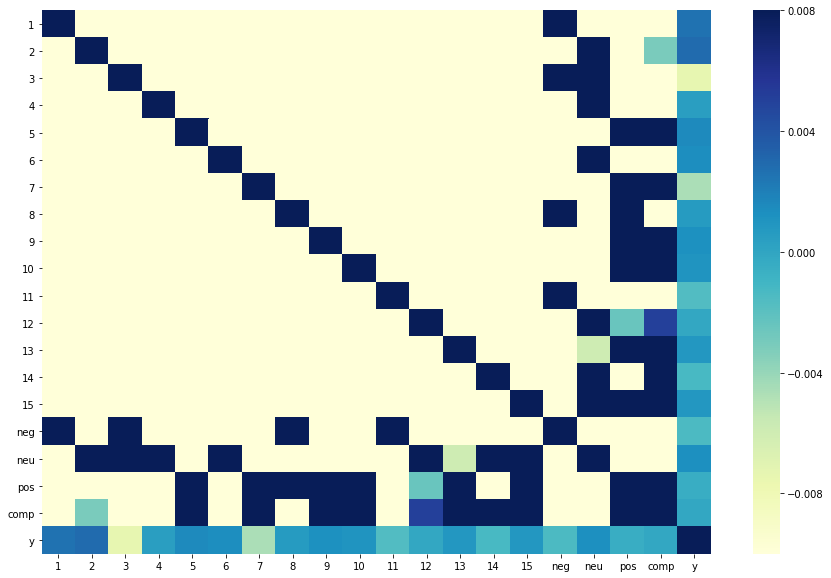

In [43]:
figure(figsize=(15,10))
sns.heatmap(corr, vmax = 0.008, vmin= -0.01, cmap="YlGnBu")

In [ ]:
outfile = '../data/x.npy'
np.save(outfile, X_sent)

In [ ]:
outfile = '../data/y.npy'
np.save(outfile, y)

In [ ]:
# run below for model selection

In [ ]:
def model_selection(n_features, param_type, X, y, act_lst = [tf.nn.relu], node_lst = [800], 
                    loss_lst = ['mse'], n_folds = 10, epochs = 1, n_output = 5):
    
    _accuracy = []
    
    if param_type == 'nodes':
        for j, n_node in enumerate(node_lst):
            print("Training Model ", j+1, ".....\n\n")
            model = init_model(n_features, act = act_lst[0], n_nodes1 = n_node,
                               loss = loss_lst[0], n_output = n_output)
            _, accuracy = run_tf(model, X, y, X, y, epochs = epochs)
            _accuracy.append(accuracy)
        
    if param_type == 'act':
        for j, act in enumerate(act_lst):
            print("Training Model ", j+1, ".....\n\n")
            model = init_model(n_features, act = act, n_nodes1 = node_lst[0],
                               loss = loss_lst[0], n_output = n_output)
            _, accuracy = run_tf(model, X, y, X, y, epochs = epochs)
            _accuracy.append(accuracy)
            
    return _accuracy

In [ ]:
# optimizing activation functions
#act_lst = [keras.activations.linear, tf.nn.sigmoid, tf.nn.relu, tf.nn.leaky_relu, keras.losses.binary_crossentropy]
#node_lst = [800]
#result = model_selection(n_features = n_features,node_lst=node_lst, param_type = 'act',
#                         X= X, y = y,
#                         act_lst = act_lst, epochs = 2, n_output = 1)

In [ ]:
#result

In [ ]:
#optimizing nodes
#act_lst = [tf.nn.relu]
#node_lst = [4000, 2000, 1000, 800, 500]
#result = model_selection(n_features = n_features,node_lst=node_lst, param_type = 'nodes',
#                         X=X, y = y,
#                         act_lst = act_lst, epochs = 2)